In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import nawrapper.ps as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

Let's generate a random map to try doing analysis on.

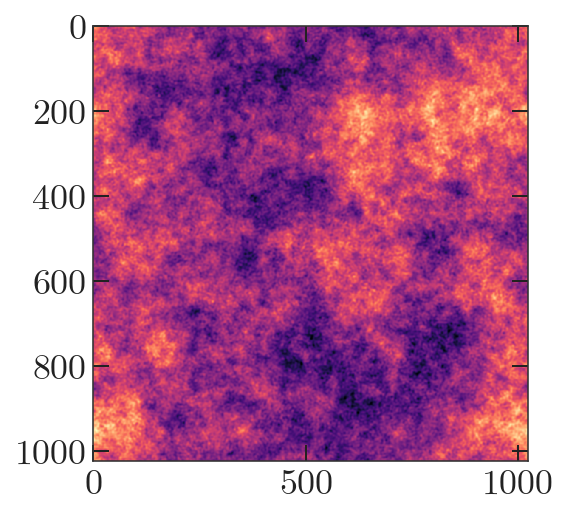

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[1:] = 1/ells[1:]**2.5
ps[:2] = 0
imap = enmap.rand_map(shape,wcs,ps[None,None])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

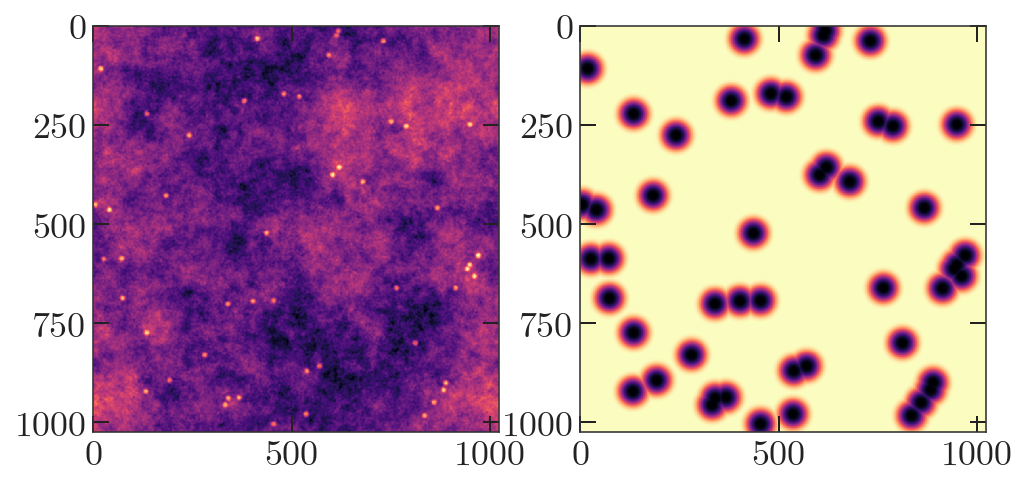

In [4]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0

point_source_map = 1-nw.apod_C2(mask, 0.1)
imap += point_source_map
mask = nw.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8,16))

axes[0].imshow(imap)
axes[1].imshow(mask)

Now let's do two noise realizations.

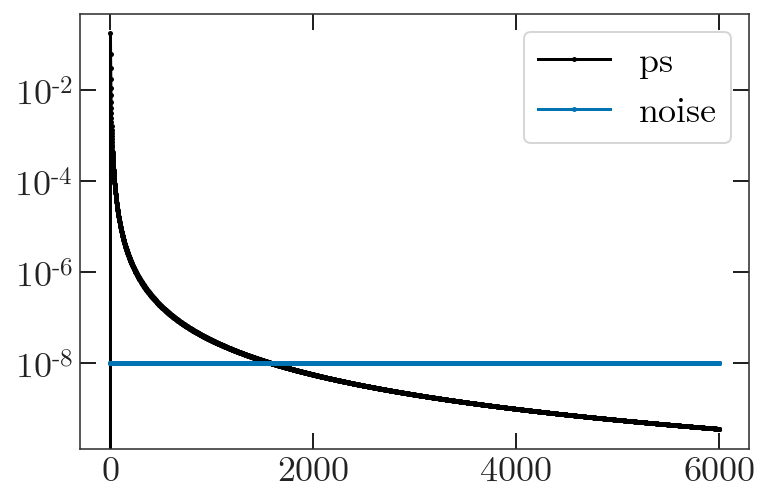

In [5]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8
plt.plot(ps, label="ps")
plt.plot(nl, label="noise")
plt.yscale('log')
plt.legend()

In [6]:
noise_map_1 = enmap.rand_map(shape,wcs,nl[None,None])
noise_map_2 = enmap.rand_map(shape,wcs,nl[None,None])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap(map_I=imap + noise_map_1, mask=mask)
namap_2 = nw.namap(map_I=imap + noise_map_2, mask=mask)

Now let's compute the mode coupling matrix. We will need a binning file.

In [8]:
binfile = 'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile)
mc = nw.mode_coupling(namap_1, namap_2, bins)

Finally, we can compute some spectra!

In [9]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb)

{'TT': array([ 8.95830369e-05,  4.14266907e-06,  7.86970343e-06,  1.99949628e-06,
        1.45248564e-06,  1.77831379e-06,  2.81867681e-07,  3.47969802e-07,
        1.18671069e-07,  2.23725922e-07,  1.45911253e-07,  1.15610606e-07,
        8.07928229e-08,  9.77519753e-08,  3.76993941e-08,  5.22742403e-08,
        4.28680457e-08,  2.93589568e-08,  3.13562629e-08,  4.28713529e-08,
        3.21248376e-08,  1.53915818e-08,  2.17825341e-08,  2.25637179e-08,
        2.22240774e-08,  1.50255414e-08,  1.51749461e-08,  1.31682888e-08,
        9.78195729e-09,  1.26038826e-08,  1.02653944e-08,  9.90191968e-09,
        7.65938612e-09,  5.99282120e-09,  8.00770926e-09,  8.58461900e-09,
        3.65330626e-09,  4.63774456e-09,  7.88993452e-09,  8.90960416e-09,
        4.13515230e-09,  4.92491322e-09,  4.24489651e-09,  2.98012542e-09,
        3.65878228e-09,  2.26199035e-09,  2.67018884e-09,  1.84971293e-09,
        1.51529294e-09,  1.37570045e-09,  9.32660117e-10,  9.06466852e-10,
        3.15835472

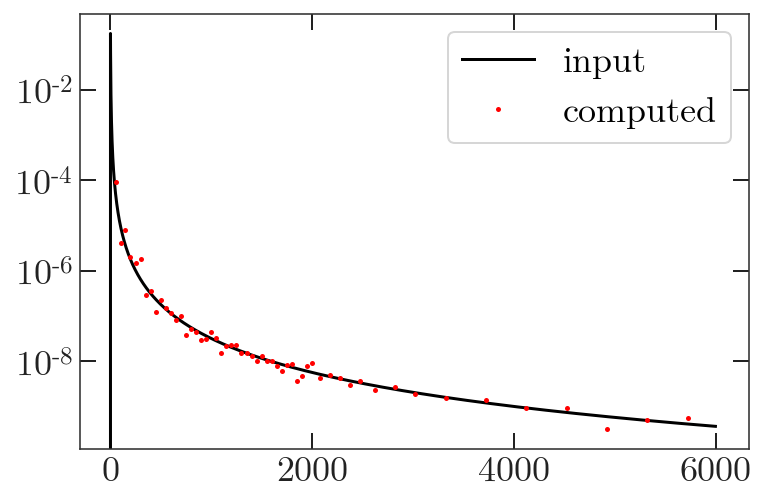

In [10]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')